In [1]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify
import matplotlib.ticker as ticker
import random

from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

In [77]:
sweep_size = 10

id_sweep = np.linspace(1e-6, 20e-6, sweep_size)
w_sweep = np.logspace(0, 4, sweep_size)
vds_sweep = np.linspace(0.1, 3.3, sweep_size)
vgs_sweep = np.linspace(0.1, 1.8, 20)

In [115]:
ihp_transistor_1w = Transistor(
            "../../LUTs/IHP_LUT_hv_1w.npy",
            "nmos",
            0,
            1.8,
            (0, 2, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['length', 'vgs'],
            [
                lengths,
                vgs_sweep,
            ],
        )

ihp_transistor_5w = Transistor(
            "../../LUTs/IHP_LUT_hv.npy",
            "nmos",
            0,
            1.8,
            (0, 2, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['length', 'vgs'],
            [
                lengths,
                vgs_sweep,
            ],
        )

ihp_transistor_20w = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            1.8,
            (0, 2, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['length', 'vgs'],
            [
                lengths,
                vgs_sweep,
            ],
        )

ihp_transistor_100w = Transistor(
            "../../LUTs/IHP_LUT_hv_100w.npy",
            "nmos",
            0,
            1.8,
            (0, 2, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['length', 'vgs'],
            [
                lengths,
                vgs_sweep,
            ],
        )

length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


In [116]:

dataframes = []
for ihp_transistor in [ihp_transistor_1w, ihp_transistor_5w, ihp_transistor_20w, ihp_transistor_100w]:
    dict_aux = {}

    dict_aux["vgs"] = np.tile(vgs_sweep, 5)
    dict_aux["Lengths"] = np.repeat(lengths, len(vgs_sweep))
    dict_aux["gmid"] = ihp_transistor.gmid.flatten()
    dict_aux["gds_raw"] = ihp_transistor.gds.flatten()
    dict_aux["gdsid"]=dict_aux["gds_raw"]/ihp_transistor.id.flatten()
    dict_aux["cgg"] = ihp_transistor.cgg.flatten()
    dict_aux["jd"]=ihp_transistor.jd.flatten()/1e6
    dict_aux["gmd"]=dict_aux["gmid"]*dict_aux["jd"]
    dict_aux["vov"]=dict_aux["vgs"]-ihp_transistor.vth.flatten()
    dict_aux["gain"]=20*np.log10(dict_aux["gmid"]/dict_aux["gdsid"])

    df_ihp_1 = pd.DataFrame.from_dict(dict_aux)
    df_size = len(df_ihp_1)

    dict_aux = {}

    dict_aux["vgs"] = np.repeat(df_ihp_1["vgs"], sweep_size)
    dict_aux["vov"] = np.repeat(df_ihp_1["vov"], sweep_size)
    dict_aux["id"] = np.tile(id_sweep, df_size)
    dict_aux["W"] = np.dot(1/df_ihp_1["jd"].values.reshape(df_size,1), id_sweep.reshape(1,sweep_size)).flatten()
    dict_aux["L"] = np.repeat(df_ihp_1["Lengths"].values, sweep_size).flatten()*1e6
    dict_aux["area"] = dict_aux["W"] + dict_aux["L"]
    dict_aux["vgs"] = np.repeat(df_ihp_1["vgs"], sweep_size)
    dict_aux["gmid"] = np.repeat(df_ihp_1["gmid"], sweep_size)
    dict_aux["gm"] = np.dot(df_ihp_1["gmid"].values.reshape(df_size,1), id_sweep.reshape(1,sweep_size)).flatten()
    dict_aux["gds"] = np.dot(df_ihp_1["gdsid"].values.reshape(df_size,1), id_sweep.reshape(1,sweep_size)).flatten()
    dict_aux["cgg"] = (np.repeat(df_ihp_1["cgg"].values, sweep_size).flatten()*dict_aux["W"])/5
    dict_aux["jd"] = np.repeat(df_ihp_1["jd"], sweep_size)

    dict_aux["size"] = dict_aux["W"]+dict_aux["L"]
    dict_aux["gbw"] = (dict_aux["gm"]/(1e-12*2*np.pi))/1e6
    dict_aux["fT"] = (dict_aux["gm"]/dict_aux["cgg"])/(2e6*np.pi)

    example_df = pd.DataFrame.from_dict(dict_aux)

    example_df = example_df[example_df["L"]<0.6]
    example_df_size = len(example_df)
    print(example_df)
    #example_df = example_df[(example_df["W"]>5) & (example_df["W"]<10000)]
    example_df = example_df.reset_index()

    #indexes = random.sample(range(1, len(example_df)), 10)
    indexes = list(range(1, example_df_size, 1))
    indexes.sort()
    random_df = example_df.loc[indexes].copy()

    W = random_df["W"].values.round(3)
    L = random_df["L"].values.round(3)
    I = random_df["id"].values.round(decimals=8)
    mult_diff = np.ones(len(indexes))

    values = {
        "XM1": [
            W,
            L,
            mult_diff,
            "nfet",
        ],
        "I1": I
    }

    simulation_results = spice_sim("LUTs_test", values)



    # gm_diff id_diff gds_diff cgg_diff

    sim_gm = []
    sim_gds = []
    sim_cgg = []
    sim_id = []
    sim_gmid = []

    for df in simulation_results:
        sim_gm.append(float(df.columns[1]))
        try:
            sim_id.append(float(df.columns[3]))
            sim_gmid.append(float(df.columns[1])/float(df.columns[3]))
        except:
            print("aqui invalido")
            sim_id.append(None)
            sim_gmid.append(None)
        sim_gds.append(float(df.columns[5]))
        sim_cgg.append(float(df.columns[7]))

    random_df["gm_error"] = (np.abs(np.asarray(sim_gm) - example_df.iloc[indexes]["gm"].values)/np.asarray(sim_gm))*100
    random_df["gds_error"] = (np.abs(np.asarray(sim_gds) - example_df.iloc[indexes]["gds"].values)/np.asarray(sim_gds))*100
    #random_df["id"] = sim_id
    random_df["cgg_error"] = (np.abs(np.asarray(sim_cgg) - example_df.iloc[indexes]["cgg"].values)/np.asarray(sim_cgg))*100

    random_df["id_sim"] = sim_id
    random_df["gmid_sim"] = sim_gmid
    random_df["gmid_error"] = (np.abs(random_df["gmid_sim"]-random_df["gmid"])/random_df["gmid_sim"])*100

    dataframes.append(random_df)



    vgs       vov        id             W    L          area       gmid  \
0   0.1 -0.463668  0.000001  3.315878e+05  0.4  3.315882e+05  25.427573   
0   0.1 -0.463668  0.000003  1.031606e+06  0.4  1.031607e+06  25.427573   
0   0.1 -0.463668  0.000005  1.731625e+06  0.4  1.731625e+06  25.427573   
0   0.1 -0.463668  0.000007  2.431644e+06  0.4  2.431644e+06  25.427573   
0   0.1 -0.463668  0.000009  3.131662e+06  0.4  3.131663e+06  25.427573   
..  ...       ...       ...           ...  ...           ...        ...   
19  1.8  1.230967  0.000012  5.804796e-02  0.4  4.580480e-01   1.164703   
19  1.8  1.230967  0.000014  6.865288e-02  0.4  4.686529e-01   1.164703   
19  1.8  1.230967  0.000016  7.925780e-02  0.4  4.792578e-01   1.164703   
19  1.8  1.230967  0.000018  8.986271e-02  0.4  4.898627e-01   1.164703   
19  1.8  1.230967  0.000020  1.004676e-01  0.4  5.004676e-01   1.164703   

          gm           gds           cgg            jd          size  \
0   0.000025  6.590909e-07 

In [117]:
dataframes[0]["id_sim"] = sim_id
dataframes[0]["gmid_sim"] = sim_gmid
dataframes[0]["gmid_error"] = (np.abs(dataframes[0]["gmid_sim"]-dataframes[0]["gmid"])/dataframes[0]["gmid_sim"])*100
dataframes[0]

,index,vgs,vov,id,W,L,area,gmid,gm,gds,...,jd,size,gbw,fT,gm_error,gds_error,cgg_error,id_sim,gmid_sim,gmid_error
1,0,0.1,-0.463668,0.000003,1.031606e+06,0.4,1.031607e+06,25.427573,0.000079,2.050505e-06,...,3.015793e-12,1.031607e+06,12.590430,0.179253,0.971543,4.025023,80.299191,0.000003,25.384003,0.171641
2,0,0.1,-0.463668,0.000005,1.731625e+06,0.4,1.731625e+06,25.427573,0.000133,3.441919e-06,...,3.015793e-12,1.731625e+06,21.133936,0.179253,0.964638,4.032275,80.299260,0.000005,25.383973,0.171761
3,0,0.1,-0.463668,0.000007,2.431644e+06,0.4,2.431644e+06,25.427573,0.000186,4.833333e-06,...,3.015793e-12,2.431644e+06,29.677442,0.179253,0.961709,4.035352,80.299290,0.000007,25.383960,0.171813
4,0,0.1,-0.463668,0.000009,3.131662e+06,0.4,3.131663e+06,25.427573,0.000240,6.224747e-06,...,3.015793e-12,3.131663e+06,38.220948,0.179253,0.960089,4.037054,80.299306,0.000009,25.383953,0.171841
5,0,0.1,-0.463668,0.000012,3.831681e+06,0.4,3.831681e+06,25.427573,0.000294,7.616161e-06,...,3.015793e-12,3.831681e+06,46.764454,0.179253,1.045899,3.946928,80.298785,0.000012,25.384280,0.170547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,19,1.8,1.230967,0.000012,5.804796e-02,0.4,4.580480e-01,1.164703,0.000013,6.970614e-07,...,1.990691e-04,4.580480e-01,2.142034,156153.108801,inf,81.221807,55.630849,NaN,NaN,NaN
196,19,1.8,1.230967,0.000014,6.865288e-02,0.4,4.686529e-01,1.164703,0.000016,8.244091e-07,...,1.990691e-04,4.686529e-01,2.533367,156153.108801,inf,80.548567,68.400517,NaN,NaN,NaN
197,19,1.8,1.230967,0.000016,7.925780e-02,0.4,4.792578e-01,1.164703,0.000018,9.517568e-07,...,1.990691e-04,4.792578e-01,2.924700,156153.108801,81.197980,91.673945,35.371814,0.000016,5.016139,76.780880
198,19,1.8,1.230967,0.000018,8.986271e-02,0.4,4.898627e-01,1.164703,0.000021,1.079105e-06,...,1.990691e-04,4.898627e-01,3.316033,156153.108801,70.710510,88.870181,31.691976,0.000018,3.939276,70.433567


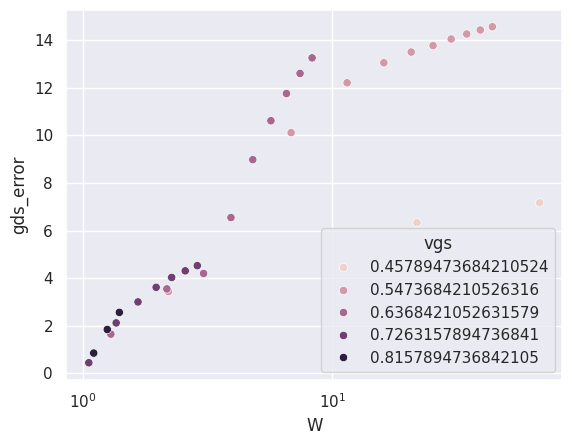

In [126]:
sns.scatterplot(data=dataframes[0][(dataframes[0]["W"]>1) & (dataframes[0]["W"]<100)], x="W", y="gds_error", hue="vgs")
plt.xscale("log")

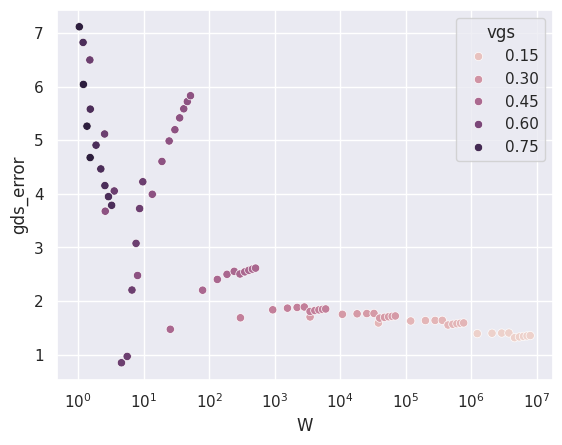

In [124]:
sns.scatterplot(data=dataframes[1][(dataframes[1]["W"]>1)], x="W", y="gds_error", hue="vgs")
plt.xscale("log")

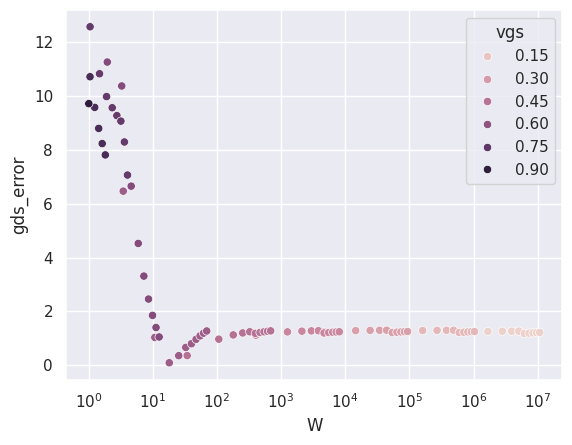

In [125]:
sns.scatterplot(data=dataframes[2][(dataframes[2]["W"]>1)], x="W", y="gds_error", hue="vgs")
plt.xscale("log")

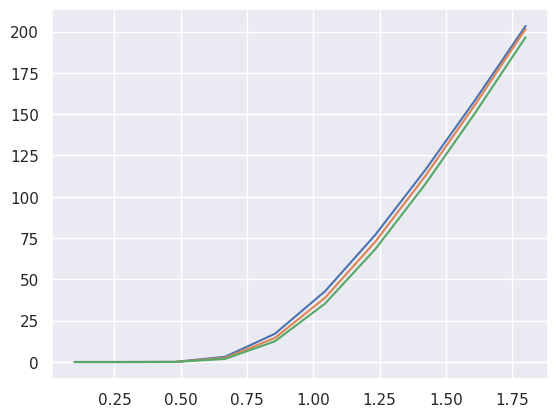

In [67]:
vgs = np.tile(vgs_sweep, 5)
plt.plot(vgs[:10], ihp_transistor_5w.jd[0])
plt.plot(vgs[:10], ihp_transistor_20w.jd[0])
plt.plot(vgs[:10], ihp_transistor_100w.jd[0])
#plt.yscale("log")

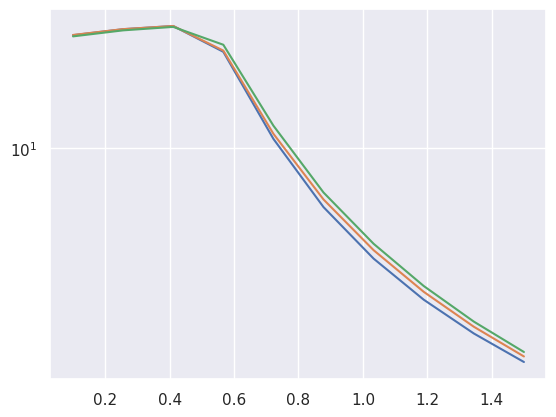

In [25]:
vgs = np.tile(vgs_sweep, 5)
plt.plot(vgs[:10], ihp_transistor_5w.gmid[0])
plt.plot(vgs[:10], ihp_transistor_20w.gmid[0])
plt.plot(vgs[:10], ihp_transistor_100w.gmid[0])
plt.yscale("log")

In [550]:
a = ((df_ihp_1["jd"].values - df_ihp["jd"].values)/df_ihp_1["jd"].values)*100

<Axes: xlabel='gmid', ylabel='jd'>

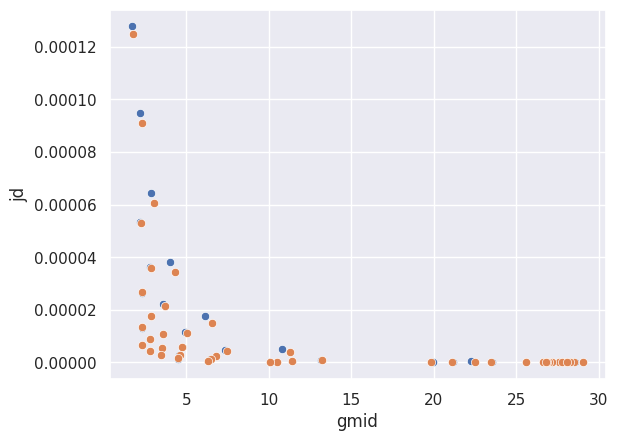

In [551]:
sns.scatterplot(data=df_ihp_1, x = "gmid", y = "jd")
sns.scatterplot(data=df_ihp, x = "gmid", y = "jd")

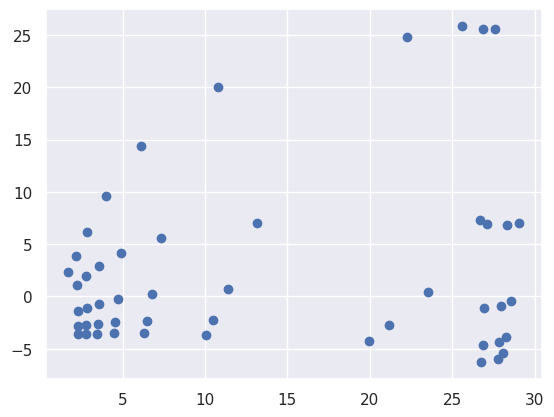

In [552]:
plt.scatter(df_ihp_1["gmid"].values, a)

In [553]:
vgs = np.tile(vgs_sweep, 5)

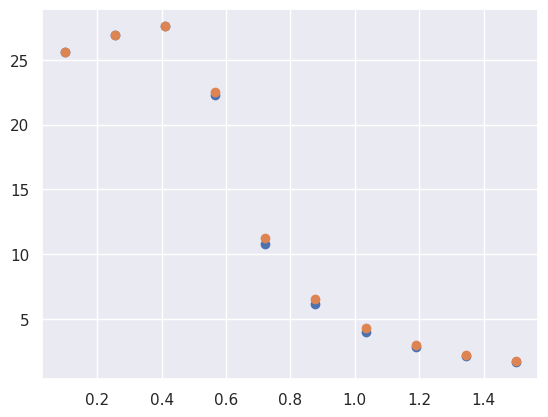

In [554]:
plt.scatter(vgs[:10], ihp_transistor_1.gmid[0])
plt.scatter(vgs[:10], ihp_transistor.gmid[0])

In [ ]:
ihp_transistor.